In [1]:
# !pip install gitpython

In [2]:
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torchvision.utils as vutils

from git import Repo
from PIL import Image
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset

In [3]:
if not os.path.exists("mnist-pngs"):
  Repo.clone_from("https://github.com/rasbt/mnist-pngs", "mnist-pngs")

### **Read the CSV**

In [4]:
df_train = pd.read_csv("./mnist-pngs/train.csv")
df_train.head()

,filepath,label
0,train/0/16585.png,0
1,train/0/24537.png,0
2,train/0/25629.png,0
3,train/0/20751.png,0
4,train/0/34730.png,0


In [5]:
df_test = pd.read_csv("./mnist-pngs/test.csv")
df_test.head()

,filepath,label
0,test/0/66062.png,0
1,test/0/64675.png,0
2,test/0/62204.png,0
3,test/0/60407.png,0
4,test/0/67368.png,0


**Shuffle the dataset**

In [6]:
df_train = pd.read_csv("mnist-pngs/train.csv")
df_train = df_train.sample(frac = 1, random_state = 123)

# Use 90% of the data as train dataset, rest 10% as validation dataset
loc = round(df_train.shape[0] * 0.9)
df_new_train = df_train.iloc[:loc]
df_new_val = df_train.iloc[loc:]

df_new_train.to_csv("mnist-pngs/new_train.csv", index = None)
df_new_val.to_csv("mnist-pngs/new_val.csv", index = None)

In [7]:
df_new_train.head()

,filepath,label
29561,train/4/38855.png,4
26640,train/4/17837.png,4
24498,train/3/7672.png,3
24594,train/3/17906.png,3
24249,train/3/41969.png,3


In [8]:
df_new_val.head()

,filepath,label
8023,train/1/9221.png,1
26302,train/4/32108.png,4
54489,train/9/7053.png,9
2712,train/0/32086.png,0
1463,train/0/12095.png,0


### **Define the Dataset class**

In [13]:
class MyDataset(Dataset):
  def __init__(self, csv_path, img_dir, transform = None):
    df = pd.read_csv(csv_path)
    self.img_dir = img_dir
    self.transform = transform

    # From the Dataframe columns
    self.img_names = df["filepath"]
    self.labels = df["label"]
  
  def __getitem__(self, idx):
    img = Image.open(os.path.join(self.img_dir, self.img_names[idx]))

    if self.transform is not None:
      img = self.transform(img)
    
    label = self.labels[idx]
    return img, label
  
  def __len__(self):
    return self.labels.shape[0]

In [14]:
def show_batch_images(batch):
  plt.figure(figsize = (8, 8))
  plt.axis("off")
  plt.title("Training images")
  plt.imshow(
    np.transpose(
      vutils.make_grid(batch[0][:64], padding = 2, normalize = True), (1, 2, 0)
    )
  )
  
  plt.show()

In [15]:
data_transforms = {
  "train": transforms.Compose(
    [
      transforms.Resize(32),
      transforms.RandomCrop((28, 28)),
      transforms.ToTensor(),
      transforms.Normalize((0.5,), (0.5,))  # Normalize the images to [-1, 1] range
    ]
  ),
  "test": transforms.Compose(
    [
      transforms.Resize(32),
      transforms.CenterCrop((28, 28)),
      transforms.ToTensor(),
      transforms.Normalize((0.5,), (0.5,))  # Normalize the images to [-1, 1] range
    ]
  )
}

In [16]:
train_dataset = MyDataset(
  csv_path = "mnist-pngs/new_train.csv",
  img_dir = "mnist-pngs/",
  transform = data_transforms["train"]
)

train_loader = DataLoader(
  dataset = train_dataset,
  batch_size = 32,
  shuffle = True,
  num_workers = 2
)

In [17]:
val_dataset = MyDataset(
  csv_path = "mnist-pngs/new_val.csv",
  img_dir = "mnist-pngs/",
  transform = data_transforms["test"]
)

val_loader = DataLoader(
  dataset = val_dataset,
  batch_size = 32,
  shuffle = False,
  num_workers = 2
)

In [18]:
test_dataset = MyDataset(
  csv_path = "mnist-pngs/test.csv",
  img_dir = "mnist-pngs/",
  transform = data_transforms["test"]
)

train_loader = DataLoader(
  dataset = test_dataset,
  batch_size = 32,
  shuffle = False,
  num_workers = 2
)

**Test for $1$ epoch**

 Batch index: 0 | Batch size: 32 | x shape: torch.Size([32, 1, 28, 28]) | y shape: torch.Size([32])
 Batch index: 1 | Batch size: 32 | x shape: torch.Size([32, 1, 28, 28]) | y shape: torch.Size([32])
 Batch index: 2 | Batch size: 32 | x shape: torch.Size([32, 1, 28, 28]) | y shape: torch.Size([32])
Labels from current batch: tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0])


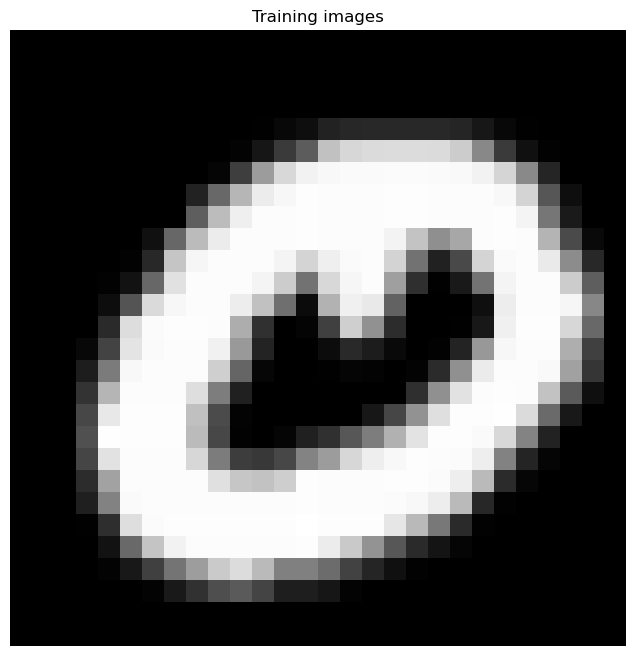

In [19]:
epochs = 1

for epoch in range(epochs):
  for batch_idx, (x, y) in enumerate(train_loader):
    if batch_idx >= 3:
      break

    print(" Batch index:", batch_idx, end = "")
    print(" | Batch size:", y.shape[0], end = "")
    print(" | x shape:", x.shape, end = "")
    print(" | y shape:", y.shape)

print("Labels from current batch:", y)

batch = next(iter(train_loader))
show_batch_images(batch[0])